In [1]:
using BenchmarkTools, Test
using Images
using OffsetArrays

### 1. Julia 的下标索引规则

在对多维数组进行下标索引 `A[I_1, I_2, ..., I_n]` 时，每一个 `I_k` 都可以是下面三种情况的任意一种：

* 标量，例如 `A[1]` `A[1, 2]`
* 一组标量组成的矩阵（或可以像矩阵一样工作的结构），例如 `A[[1, 3]]`, `A[1:3]`
* 可以转换成第二种情况的数据，例如 `A[:, :]`

针对这几种索引的类型，Julia 有三条索引的规则：

* 坐标索引 (Cartesian Indexing)，例如 `A[1, 2, 3]`
* 线性索引 (Linear Indexing)，例如 `A[5]`
* 特殊情况：是否可以省略额外的 `:`

下面先介绍这三种规则下各种类型的索引是如何使用的

In [2]:
# 简单起见，先构造一个比较小的数组方便观察
A = reshape(collect(1:16), 2, 4, 2)

2×4×2 Array{Int64,3}:
[:, :, 1] =
 1  3  5  7
 2  4  6  8

[:, :, 2] =
  9  11  13  15
 10  12  14  16

#### 1.1. 坐标索引

常见的 `A[1, 2]` 这种通过指定数组在每一个维度的位置来进行索引的方式，称之为坐标索引。

仅用标量进行坐标索引，最后得到的也是标量

In [3]:
A[1, 2, 2]

11

若索引中某一项改为第二类索引，即用一组标量组成的矩阵，那么最后得到的也是矩阵

In [4]:
A[1, [2, 4], 2] # 等价于 [A[1, 2, 2], A[1, 4, 2]]

2-element Array{Int64,1}:
 11
 15

In [5]:
A[[1, 2], [2, 4], 2] # 等价于 [A[1, 2, 2] A[1, 4, 2]; A[2, 2, 2] A[2, 4, 2]]

2×2 Array{Int64,2}:
 11  15
 12  16

In [6]:
# 并不要求矩阵中每个元素都是唯一的
A[1, [2, 2, 2], 2]

3-element Array{Int64,1}:
 11
 11
 11

类似地，矩阵也可以替换成各种 Range 类型

In [7]:
A[1, 2:2:4, 2] # collect(2:2:4) == [2, 4]

2-element Array{Int64,1}:
 11
 15

在图像处理中，索引图像就是以这种方式工作的，例如

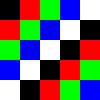

In [8]:
# 调色盘 = [黑，红，绿，蓝，白]
palette = [RGB(0.0, 0.0, 0.0), RGB(1.0, 0.0, 0.0), RGB(0.0, 1.0, 0.0), RGB(0.0, 0.0, 1.0), RGB(1.0, 1.0, 1.0)]

# idx中的每一项表示它对应的调色盘中的索引
idx = [
    1 2 3 4 5; # 黑，红，绿，蓝，白
    2 3 4 5 1; # 红，绿，蓝，白，黑
    3 4 5 1 2;
    4 5 1 2 3;
    5 1 2 3 4
]

palette[idx]

有两种比较典型的第三类索引：`:` (`Colon`) 与 二值矩阵

* 用 `:` 作下标可以作为占位符使用，表示选取对应维度的全部下标
* 用二值矩阵作为下标，则表示选取其中所有值为 `true` 的量


In [9]:
A[:, 2, 2] # 等价于 A[axes(A, 1), 2, 2]

2-element Array{Int64,1}:
 11
 12

In [10]:
A[:, :, 2] # 等价于 A[axes(A, 1), axes(A, 2), 2]

2×4 Array{Int64,2}:
  9  11  13  15
 10  12  14  16

注：不同于numpy，用 `:` 作为下标，只选取当前的维度而不会扩散到其他维度，因此在这个例子中，`A[1, :]` 或者 `A[:, 1]` 这种形式都是不可行的，需要将第三个维度的坐标加上才行

In [11]:
A[1, :, :]

4×2 Array{Int64,2}:
 1   9
 3  11
 5  13
 7  15

用逻辑值作为下标可以简单快速地把矩阵的内容筛选出来，例如：

In [12]:
I = A .> 10

2×4×2 BitArray{3}:
[:, :, 1] =
 0  0  0  0
 0  0  0  0

[:, :, 2] =
 0  1  1  1
 0  1  1  1

In [13]:
A[I]

6-element Array{Int64,1}:
 11
 12
 13
 14
 15
 16

注：用逻辑值作为下标，则必须保证索引矩阵 `I` 的尺寸与 `A` 的尺寸一致

#### 1.2. 线性索引

计算机在读取连续的内存块时性能要优于读取不连续的内存块，因此保证内存连续是处理多维数组时必须使用的技巧

如果矩阵是按列存储，而按行读取的话，那么内存是不连续的，转置矩阵就是这样一个例子

In [14]:
X = rand(64, 64);

@btime collect($(X));
@btime collect($(X')); # 将矩阵转置之后，内存不再是连续的了，因此索引的结果更慢

  1.685 μs (2 allocations: 32.08 KiB)
  6.112 μs (2 allocations: 32.08 KiB)


当对多维数组进行索引时只传递了一个下标，那么就会采用线性索引。

简单来说，**线性索引**就是将数组按照它在内存中的存储顺序展开成一列向量，然后在向量上进行对应的索引。

使用线性索引的好处是它能够保证数据一定是按照内存连续的方式进行读取

In [15]:
A[2]

2

In [16]:
# 在 Matlab 中，也可以这样做
# 在 numpy 中，这种操作是会报错的

A[15] # 等价于 A[1, 4, 2]

15

In [17]:
# 类似地，
A[length(A)] == A[end]

true

In [18]:
# 以计算两个数组的欧式距离为例 d = sqrt(∑(Xᵢ - Yᵢ))
# 这是两种基本等价的迭代方式

function my_euclidean1(X, Y)
    retval = 0.0
    @assert axes(X) == axes(Y)
    
    for i in 1:length(X)
        retval += (X[i] - Y[i])^2
    end
    return sqrt(retval)
end

function my_euclidean2(X, Y)
    retval = 0.0
    @assert axes(X) == axes(Y)
    
    for (x, y) in zip(X, Y)
        retval += (x - y)^2
    end
    return sqrt(retval)
end

my_euclidean2 (generic function with 1 method)

In [19]:
X = rand(64, 64);
Y = rand(64, 64);

@btime my_euclidean1($X, $Y);
@btime my_euclidean2($X, $Y);

  3.662 μs (0 allocations: 0 bytes)
  3.578 μs (0 allocations: 0 bytes)


In [20]:
# : 扩散到其他维度只在线性索引时才能工作

A[:] # 等价于 vec(A)

16-element Array{Int64,1}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15
 16

#### 1.3. 数组索引的一些特殊规则


* 若接下来的维度都只含有一个元素，则可以省略下标

In [21]:
A = reshape(collect(1:24), 2, 3, 1, 4, 1, 1, 1)

A[1, 1, 1, 1] # 可以省略第五个下标

1

* 若接下来的索引全为1， 则可以超出数组的维数

In [22]:
A = reshape(collect(1:24), 2, 3, 4)

A[2, 3, 4, 1, 1, 1] # works, too

24

### 2. CartesianIndex 与 多维数组

线性索引的好处是它可以保证内存的连续性，但缺点是它丢失了高维矩阵的位置信息，因此在需要涉及到对高维矩阵的位置进行交互的时候，往往还是会回到坐标索引下去工作。

滤波、卷积这类运算就是非常典型的一个例子

以均值滤波为例，在其他语言中一般会对不同维度提供一个特定的实现

In [23]:
function mean_filter_1d(X::AbstractVector; window_size=3)
    out = similar(X)
    
    δ = window_size ÷ 2
    for i in 1:length(X)
        # min, max确保下标不溢出
        l = max(1, i-δ)
        r = min(length(X), i+δ)
        
        # 计算一个局部的均值
        out[i] = mean(X[l:r])
    end
    return out
end

X = Float64.(rand(1:5, 10))
hcat(X, mean_filter_1d(X; window_size=3))

10×2 Array{Float64,2}:
 5.0  4.0
 3.0  4.0
 4.0  4.0
 5.0  4.0
 3.0  3.66667
 3.0  3.33333
 4.0  2.66667
 1.0  2.0
 1.0  1.33333
 2.0  1.5

In [24]:
function mean_filter_2d(X::AbstractMatrix; window_size=3)
    out = similar(X)
    M, N = size(X)
    
    δ = window_size ÷ 2
    for i in 1:M
        il = max(1, i-δ)
        ir = min(M, i+δ)
        
        for j in 1:N
            jl = max(1, j-δ)
            jr = min(N, j+δ)
        
            out[i, j] = mean(X[il:ir, jl:jr])
        end
    end
    return out
end

X = Float64.(rand(1:5, 5, 5))
hcat(X, mean_filter_2d(X))

5×10 Array{Float64,2}:
 3.0  1.0  2.0  5.0  1.0  1.75     2.16667  2.5      2.33333  2.0
 1.0  2.0  4.0  1.0  1.0  2.5      2.66667  3.0      2.66667  2.5
 4.0  4.0  3.0  5.0  2.0  3.33333  3.44444  3.11111  2.44444  1.83333
 5.0  4.0  4.0  1.0  1.0  3.5      3.33333  2.88889  2.44444  2.16667
 3.0  1.0  2.0  2.0  2.0  3.25     3.16667  2.33333  2.0      1.5

Julia 的 `CartesianIndex` 对于这种情形提供了一个简洁且高效的解决方案，在给出新的实现之前，先介绍 `CartesianIndex` 的基本使用

`CartesianIndex` 只是对 `Tuple` 类型的一个包装

In [25]:
I_t = (1, 2, 3)

(1, 2, 3)

In [26]:
A = reshape(collect(1:24), 2, 3, 4)

2×3×4 Array{Int64,3}:
[:, :, 1] =
 1  3  5
 2  4  6

[:, :, 2] =
 7   9  11
 8  10  12

[:, :, 3] =
 13  15  17
 14  16  18

[:, :, 4] =
 19  21  23
 20  22  24

In [27]:
A[I_t] # Tuple 类型不能作为索引使用

ArgumentError: ArgumentError: invalid index: (1, 2, 3) of type Tuple{Int64,Int64,Int64}

In [28]:
I = CartesianIndex(I_t)

CartesianIndex(1, 2, 3)

In [29]:
A[I] # 等价于 A[1, 2, 3]

15

在对 `Tuple` 进行包装的基础上，`CartesianIndex` 上有一些额外的下标操作

比如说，用 `:` 来构造一组 `CartesianIndex` 的下标

In [30]:
I1 = CartesianIndex(1, 2, 2)
I2 = CartesianIndex(1, 3, 4)

I1:I2 # CartesianIndices 实际上就是 Array{CartesianIndex}

1×2×3 CartesianIndices{3,Tuple{UnitRange{Int64},UnitRange{Int64},UnitRange{Int64}}}:
[:, :, 1] =
 CartesianIndex(1, 2, 2)  CartesianIndex(1, 3, 2)

[:, :, 2] =
 CartesianIndex(1, 2, 3)  CartesianIndex(1, 3, 3)

[:, :, 3] =
 CartesianIndex(1, 2, 4)  CartesianIndex(1, 3, 4)

In [31]:
A[I1:I2] # 等价于 A[1:1, 2:3, 2:4]

1×2×3 Array{Int64,3}:
[:, :, 1] =
 9  11

[:, :, 2] =
 15  17

[:, :, 3] =
 21  23

也可以用 `CartesianIndices` 来快速构造对应矩阵的下标

In [32]:
CartesianIndices(A) # A 的所有下标

2×3×4 CartesianIndices{3,Tuple{Base.OneTo{Int64},Base.OneTo{Int64},Base.OneTo{Int64}}}:
[:, :, 1] =
 CartesianIndex(1, 1, 1)  CartesianIndex(1, 2, 1)  CartesianIndex(1, 3, 1)
 CartesianIndex(2, 1, 1)  CartesianIndex(2, 2, 1)  CartesianIndex(2, 3, 1)

[:, :, 2] =
 CartesianIndex(1, 1, 2)  CartesianIndex(1, 2, 2)  CartesianIndex(1, 3, 2)
 CartesianIndex(2, 1, 2)  CartesianIndex(2, 2, 2)  CartesianIndex(2, 3, 2)

[:, :, 3] =
 CartesianIndex(1, 1, 3)  CartesianIndex(1, 2, 3)  CartesianIndex(1, 3, 3)
 CartesianIndex(2, 1, 3)  CartesianIndex(2, 2, 3)  CartesianIndex(2, 3, 3)

[:, :, 4] =
 CartesianIndex(1, 1, 4)  CartesianIndex(1, 2, 4)  CartesianIndex(1, 3, 4)
 CartesianIndex(2, 1, 4)  CartesianIndex(2, 2, 4)  CartesianIndex(2, 3, 4)

以及坐标的偏移等计算

In [33]:
δ = CartesianIndex(1, 1)
I = CartesianIndex(3, 3)

# 构造了一组以(3, 3)为中心的坐标
I-δ:I+δ

3×3 CartesianIndices{2,Tuple{UnitRange{Int64},UnitRange{Int64}}}:
 CartesianIndex(2, 2)  CartesianIndex(2, 3)  CartesianIndex(2, 4)
 CartesianIndex(3, 2)  CartesianIndex(3, 3)  CartesianIndex(3, 4)
 CartesianIndex(4, 2)  CartesianIndex(4, 3)  CartesianIndex(4, 4)

In [34]:
I_first = CartesianIndex(1, 1)
I_last = CartesianIndex(5, 5)

I = CartesianIndex(1, 1)
δ = CartesianIndex(1, 1)

I-δ:I+δ

3×3 CartesianIndices{2,Tuple{UnitRange{Int64},UnitRange{Int64}}}:
 CartesianIndex(0, 0)  CartesianIndex(0, 1)  CartesianIndex(0, 2)
 CartesianIndex(1, 0)  CartesianIndex(1, 1)  CartesianIndex(1, 2)
 CartesianIndex(2, 0)  CartesianIndex(2, 1)  CartesianIndex(2, 2)

为了让 `I-δ:I+δ` 在有效的区域内，比如说在 `I_first:I_last` 之间，可以使用 `min`, `max` 等工具来进行处理

以下两种都是常见的处理策略：

In [35]:
max(I_first, I-δ) : min(I_last, I+δ)

# 一些负的坐标被移除了

2×2 CartesianIndices{2,Tuple{UnitRange{Int64},UnitRange{Int64}}}:
 CartesianIndex(1, 1)  CartesianIndex(1, 2)
 CartesianIndex(2, 1)  CartesianIndex(2, 2)

大致理解的话，`CartesianIndex` 可以帮助我们将多维下标的处理抽象出来，从而来避免复杂的for循环

回到之前的均值滤波操作，我们可以用 `CartesianIndex` 将它改写成一般形式

```julia
function mean_filter_1d(X::AbstractVector; window_size=3)
    out = similar(X)
    
    δ = window_size ÷ 2
    for i in 1:length(X)
        # min, max确保下标不溢出
        l = max(1, i-δ)
        r = min(length(X), i+δ)
        
        # 计算一个局部的均值
        out[i] = mean(X[l:r])
    end
    return out
end
```

In [36]:
# 这个函数可以对任意维的矩阵进行迭代

function mean_filter(X; window_size=3)
    out = similar(X)
    
    δ = CartesianIndex(ntuple(_ -> window_size÷2, ndims(X)))

    R = CartesianIndices(X)
    I_first, I_last = first(R), last(R)
    
    for i in R
        Rᵢ = max(I_first, i-δ) : min(I_last, i+δ)
        out[i] = mean(X[Rᵢ])
    end
    return out
end

mean_filter (generic function with 1 method)

In [37]:
# 一维
X = Float64.(rand(1:5, 10))
mean_filter(X);

# 二维
X = Float64.(rand(1:5, 10, 10))
mean_filter(X);

# 3维 -- 滑动窗口是一个三维立体
X = Float64.(rand(1:5, 10, 10, 3))
mean_filter(X);

### 3. view and copy

在对矩阵进行取下标操作时，默认的方式是 `copy`

In [38]:
A

2×3×4 Array{Int64,3}:
[:, :, 1] =
 1  3  5
 2  4  6

[:, :, 2] =
 7   9  11
 8  10  12

[:, :, 3] =
 13  15  17
 14  16  18

[:, :, 4] =
 19  21  23
 20  22  24

In [39]:
s1 = A[:, :, 1]

fill!(s1, 0) # 因为 s1 是通过复制得到的，所以修改 s1 不会修改 A 的值
s1

2×3 Array{Int64,2}:
 0  0  0
 0  0  0

In [40]:
A

2×3×4 Array{Int64,3}:
[:, :, 1] =
 1  3  5
 2  4  6

[:, :, 2] =
 7   9  11
 8  10  12

[:, :, 3] =
 13  15  17
 14  16  18

[:, :, 4] =
 19  21  23
 20  22  24

这样做是比较安全的，可以避免以外的数据修改，但在很多时候，这样做会带来大量额外的内存开销。

在 Julia 下，可以通过 `view`, `@view` 或者 `@views` 来避免数据的复制

In [41]:
s2 = @view A[:, :, 1] # view(A, :, :, 1)
fill!(s2, 0) # 因为 s1 是通过 view 得到的，所以修改 s1 会同样修改 A 的值
s2

2×3 view(::Array{Int64,3}, :, :, 1) with eltype Int64:
 0  0  0
 0  0  0

In [42]:
A

2×3×4 Array{Int64,3}:
[:, :, 1] =
 0  0  0
 0  0  0

[:, :, 2] =
 7   9  11
 8  10  12

[:, :, 3] =
 13  15  17
 14  16  18

[:, :, 4] =
 19  21  23
 20  22  24

之前的 `mean_filter` 这个函数就可以通过这一点来进行优化

In [43]:
# 这个函数可以对任意维的矩阵进行迭代

function mean_filter(X; window_size=3)
    out = similar(X)
    
    δ = CartesianIndex(ntuple(_ -> window_size÷2, ndims(X)))

    R = CartesianIndices(X)
    I_first, I_last = first(R), last(R)
    
    for i in R
        Rᵢ = max(I_first, i-δ) : min(I_last, i+δ)
        out[i] = mean(X[Rᵢ])
    end
    return out
end

@btime mean_filter($X);

  24.002 μs (303 allocations: 69.38 KiB)


In [44]:
# 这个函数可以对任意维的矩阵进行迭代

function mean_filter(X; window_size=3)
    out = similar(X)
    
    δ = CartesianIndex(ntuple(_ -> window_size÷2, ndims(X)))

    R = CartesianIndices(X)
    I_first, I_last = first(R), last(R)
    
    for i in R
        Rᵢ = max(I_first, i-δ) : min(I_last, i+δ)
        out[i] = mean(@view X[Rᵢ]) # 这里只创建 view 从而避免额外的性能开销
    end
    return out
end

@btime mean_filter($X);

  14.130 μs (3 allocations: 2.56 KiB)
